In [2]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report

# --------------------------
# PARÁMETROS GENERALES
# --------------------------

ruta_matriz = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_guardado_base = "/home/alumno08/TFM/fase2/9_correciones_modelo"
os.makedirs(ruta_guardado_base, exist_ok=True)

ruta_cluster_genus = "/home/alumno08/TFM/fase2/9_correciones_modelo/genus_clustering_con_rendimiento.tsv"
ruta_cluster_species = "/home/alumno08/TFM/fase2/9_correciones_modelo/species_clustering_con_rendimiento.tsv"

random_state = 42
niveles_tax = ["Kingdom", "Phylum", "Class", "Family", "Genus", "Species"]

# --------------------------
# CARGA DE DATOS Y PHROGs
# --------------------------

df = pd.read_csv(ruta_matriz, sep="\t", index_col=0, low_memory=False)
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]
df = df.dropna(subset=niveles_tax)

phrogs_especificos = {}
phrogs_caracteristicos = {}

for nivel in niveles_tax:
    ruta_esp = f"{ruta_phrogs}/phrogs_especificos_por_{nivel.lower()}.tsv"
    ruta_carac = f"{ruta_phrogs}/phrogs_caracteristicos_por_{nivel.lower()}.tsv"
    df_esp = pd.read_csv(ruta_esp, sep="\t")
    df_carac = pd.read_csv(ruta_carac, sep="\t")
    phrogs_especificos[nivel] = df_esp
    phrogs_caracteristicos[nivel] = df_carac

# --------------------------
# GENERACIÓN DE NUEVOS PREDICTORES
# --------------------------

df_extra = pd.DataFrame(index=df.index)
for nivel in niveles_tax:
    df_esp = phrogs_especificos[nivel]
    df_carac = phrogs_caracteristicos[nivel]
    num_esp, num_carac = [], []
    for idx, fila in df.iterrows():
        grupo = fila[nivel]
        phrogs_esp_grupo = df_esp[grupo].dropna().tolist() if grupo in df_esp.columns else []
        phrogs_carac_grupo = df_carac[grupo].dropna().tolist() if grupo in df_carac.columns else []
        presentes = fila[phrog_cols][fila[phrog_cols] == 1].index.tolist()
        num_esp.append(len(set(presentes) & set(phrogs_esp_grupo)))
        num_carac.append(len(set(presentes) & set(phrogs_carac_grupo)))
    df_extra[f"especificos_{nivel.lower()}"] = num_esp
    df_extra[f"caracteristicos_{nivel.lower()}"] = num_carac

# --------------------------
# MATRIZ FINAL Y FILTRADO POR CLASES CON ≥ 2 MUESTRAS
# --------------------------

X = pd.concat([df[phrog_cols], df_extra], axis=1)
Y = df[niveles_tax]
clases_validas = Y["Class"].value_counts()[Y["Class"].value_counts() >= 2].index
X_filtrado = X[Y["Class"].isin(clases_validas)]
Y_filtrado = Y[Y["Class"].isin(clases_validas)]

# --------------------------
# SPLIT Y ENTRENAMIENTO
# --------------------------

X_train, X_test, y_train, y_test = train_test_split(X_filtrado, Y_filtrado, test_size=0.2, stratify=Y_filtrado["Class"], random_state=random_state)

param_grid = {'estimator__n_estimators': [100],'estimator__max_depth': [None, 10],'estimator__class_weight': ['balanced']}
rf = RandomForestClassifier(random_state=random_state)
multi_rf = MultiOutputClassifier(rf)
grid = GridSearchCV(multi_rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
mejor_modelo = grid.best_estimator_

# --------------------------
# EVALUACIÓN Y GUARDADO DEL MODELO
# --------------------------

y_pred = mejor_modelo.predict(X_test)
y_pred_df = pd.DataFrame(y_pred, columns=niveles_tax, index=X_test.index)
for nivel in niveles_tax:
    print(f"\nReporte para {nivel}:")
    print(classification_report(y_test[nivel], y_pred_df[nivel]))
    df_reporte = pd.DataFrame(classification_report(y_test[nivel], y_pred_df[nivel], output_dict=True)).transpose()
    df_reporte.to_csv(f"{ruta_guardado_base}/clasificacion_{nivel.lower()}_opt.tsv", sep="\t")

with open(f"{ruta_guardado_base}/modelo_rf_multinivel.pkl", "wb") as f:
    pickle.dump(mejor_modelo, f)

# --------------------------
# PREDICCIÓN COMPLETA CON AVISOS
# --------------------------

tabla_clusters_genus = pd.read_csv(ruta_cluster_genus, sep="\t")
tabla_clusters_species = pd.read_csv(ruta_cluster_species, sep="\t")
X_total = pd.concat([df[phrog_cols], df_extra], axis=1)
y_total_pred = mejor_modelo.predict(X_total)
df_total_pred = pd.DataFrame(y_total_pred, columns=niveles_tax, index=df.index)
probas_total = mejor_modelo.predict_proba(X_total)

avisos = []
for i in range(X_total.shape[0]):
    genus_pred = df_total_pred.iloc[i]["Genus"]
    species_pred = df_total_pred.iloc[i]["Species"]
    conf_genus = np.max(probas_total[4][i])
    conf_species = np.max(probas_total[5][i])
    aviso = []
    info_genus = tabla_clusters_genus[tabla_clusters_genus["Genus"].str.lower() == genus_pred.lower()]
    if not info_genus.empty and info_genus.iloc[0]["cluster"] in [0, 1]:
        aviso.append("Genus en cluster problemático")
    if conf_genus < 0.7:
        aviso.append("Baja confianza Genus")
    info_species = tabla_clusters_species[tabla_clusters_species["Species"].str.lower() == species_pred.lower()]
    if not info_species.empty and info_species.iloc[0]["cluster"] != 3:
        aviso.append("Species en cluster problemático")
    if conf_species < 0.7:
        aviso.append("Baja confianza Species")
    avisos.append("; ".join(aviso) if aviso else "OK")

df_total_pred["Confianza_Genus"] = [np.max(p) for p in probas_total[4]]
df_total_pred["Confianza_Species"] = [np.max(p) for p in probas_total[5]]
df_total_pred["Aviso"] = avisos
df_total_pred.to_csv(f"{ruta_guardado_base}/predicciones_completas_con_avisos.tsv", sep="\t")

print(f"\n Modelo y predicciones completas con avisos guardadas en: {ruta_guardado_base}")

/tmp/ipykernel_494212/1842312909.py:40: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261

Fitting 3 folds for each of 2 candidates, totalling 6 fits

Reporte para Kingdom:
                precision    recall  f1-score   support

  Abadenavirae       1.00      1.00      1.00         2
  Bamfordvirae       1.00      1.00      1.00         2
Heunggongvirae       1.00      1.00      1.00       662
     Loebvirae       1.00      1.00      1.00        18
 Orthornavirae       1.00      1.00      1.00       167
   Sangervirae       1.00      1.00      1.00         4

      accuracy                           1.00       855
     macro avg       1.00      1.00      1.00       855
  weighted avg       1.00      1.00      1.00       855


Reporte para Phylum:
                   precision    recall  f1-score   support

   Hofneiviricota       1.00      1.00      1.00        18
    Lenarviricota       1.00      1.00      1.00       167
     Phixviricota       1.00      1.00      1.00         4
Preplasmiviricota       1.00      1.00      1.00         2
Produgelaviricota       1.00      1.0

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz


Reporte para Species:
                                   precision    recall  f1-score   support

                Abidjanvirus Ab18       0.00      0.00      0.00         1
                Abidjanvirus ZC01       0.00      0.00      0.00         0
                 Acadevirus PM116       0.00      0.00      0.00         1
          Acadevirus bigMiraUFV01       0.00      0.00      0.00         0
                 Acadevirus premi       0.00      0.00      0.00         1
                Acanvirus Rheph16       0.00      0.00      0.00         1
                    Acanvirus Y26       0.00      0.00      0.00         0
              Actinidiaevirus Ep4       0.00      0.00      0.00         0
                 Aerosvirus ZPAH7       0.00      0.00      0.00         1
          Aerosvirus av25AhydR2PP       0.00      0.00      0.00         0
       Affertcholeramvirus CTXphi       0.00      0.00      0.00         1
      Affertcholeramvirus preCTX1       0.00      0.00      0.00         1
 

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



 Modelo y predicciones completas con avisos guardadas en: /home/alumno08/TFM/fase2/9_correciones_modelo


In [ ]:
MODELO FINAL FINAL CON MEJORAS

In [5]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# --------------------------
# PARÁMETROS GENERALES
# --------------------------

ruta_matriz = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_guardado_base = "/home/alumno08/TFM/fase2/10_modelo_final_por_nivel"
os.makedirs(ruta_guardado_base, exist_ok=True)

random_state = 42
niveles_tax = ["Kingdom", "Phylum", "Class", "Family", "Genus", "Species"]

# --------------------------
# CARGA DE DATOS Y PHROGs
# --------------------------

df = pd.read_csv(ruta_matriz, sep="\t", index_col=0, low_memory=False)
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]
df = df.dropna(subset=niveles_tax)

phrogs_especificos = {}
phrogs_caracteristicos = {}
for nivel in niveles_tax:
    ruta_esp = f"{ruta_phrogs}/phrogs_especificos_por_{nivel.lower()}.tsv"
    ruta_carac = f"{ruta_phrogs}/phrogs_caracteristicos_por_{nivel.lower()}.tsv"
    df_esp = pd.read_csv(ruta_esp, sep="\t")
    df_carac = pd.read_csv(ruta_carac, sep="\t")
    phrogs_especificos[nivel] = df_esp
    phrogs_caracteristicos[nivel] = df_carac

# --------------------------
# GENERACIÓN DE NUEVOS PREDICTORES CON REFUERZO
# --------------------------

df_extra = pd.DataFrame(index=df.index)
for nivel in niveles_tax:
    df_esp = phrogs_especificos[nivel]
    df_carac = phrogs_caracteristicos[nivel]
    num_esp, num_carac = [], []
    for idx, fila in df.iterrows():
        grupo = fila[nivel]
        phrogs_esp_grupo = df_esp[grupo].dropna().tolist() if grupo in df_esp.columns else []
        phrogs_carac_grupo = df_carac[grupo].dropna().tolist() if grupo in df_carac.columns else []
        presentes = fila[phrog_cols][fila[phrog_cols] == 1].index.tolist()
        num_esp.append(3 * len(set(presentes) & set(phrogs_esp_grupo)))
        num_carac.append(len(set(presentes) & set(phrogs_carac_grupo)))
    df_extra[f"especificos_{nivel.lower()}"] = num_esp
    df_extra[f"caracteristicos_{nivel.lower()}"] = num_carac

X = pd.concat([df[phrog_cols], df_extra], axis=1)
Y = df[niveles_tax]

# --------------------------
# PROCESO POR NIVEL TAXONÓMICO
# --------------------------

for nivel in niveles_tax:
    print(f"\n--- Procesando nivel: {nivel} ---")
    y = Y[nivel]
    clases_validas = y.value_counts()[y.value_counts() >= 2].index
    mask = y.isin(clases_validas)
    X_filtrado = X[mask]
    y_filtrado = y[mask]

    X_train, X_test, y_train, y_test = train_test_split(
        X_filtrado, y_filtrado, test_size=0.2, stratify=y_filtrado, random_state=random_state
    )

    class_weight = "balanced"
    if nivel in ["Genus", "Species"]:
        class_counts = y_train.value_counts()
        total = len(y_train)
        class_weight = {clase: total / (len(class_counts) * count) for clase, count in class_counts.items()}

    rf = RandomForestClassifier(random_state=random_state, class_weight=class_weight)
    param_grid = {"n_estimators": [100], "max_depth": [None, 10]}
    grid = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    mejor_modelo = grid.best_estimator_

    # --------------------------
    # VALIDACIÓN CRUZADA EN TRAIN
    # --------------------------
    scores = cross_val_score(mejor_modelo, X_train, y_train, cv=5)
    print(f"Validación cruzada (media ± std): {scores.mean():.3f} ± {scores.std():.3f}")

    # --------------------------
    # EVALUACIÓN EN TEST
    # --------------------------
    y_pred = mejor_modelo.predict(X_test)
    print("\nEvaluación en conjunto de test:")
    print(classification_report(y_test, y_pred))

    # --------------------------
    # GUARDADO DEL MODELO
    # --------------------------
    with open(f"{ruta_guardado_base}/modelo_{nivel.lower()}.pkl", "wb") as f:
        pickle.dump(mejor_modelo, f)
    print(f" Modelo final para {nivel} guardado.\n")

/tmp/ipykernel_580320/1067407908.py:35: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261


--- Procesando nivel: Kingdom ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.999 ± 0.001

Evaluación en conjunto de test:
                precision    recall  f1-score   support

  Abadenavirae       1.00      1.00      1.00         3
  Bamfordvirae       1.00      1.00      1.00         2
Heunggongvirae       1.00      1.00      1.00       662
     Loebvirae       1.00      1.00      1.00        17
 Orthornavirae       0.99      1.00      1.00       167
   Sangervirae       1.00      0.75      0.86         4

      accuracy                           1.00       855
     macro avg       1.00      0.96      0.98       855
  weighted avg       1.00      1.00      1.00       855

✅ Modelo final para Kingdom guardado.


--- Procesando nivel: Phylum ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.999 ± 0.001

Evaluación en conjunto de test:
                   precision    recall  f1-score   support

   Hofneiviricota       1.00      1.00      1.00        17
    Lenarviricota       0.99      1.00      1.00       167
     Phixviricota       1.00      0.75      0.86         4
Preplasmiviricota       1.00      1.00      1.00         2
Produgelaviricota       1.00      1.00      1.00         3
      Uroviricota       1.00      1.00      1.00       662

         accuracy                           1.00       855
        macro avg       1.00      0.96      0.98       855
     weighted avg       1.00      1.00      1.00       855

✅ Modelo final para Phylum guardado.


--- Procesando nivel: Class ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.999 ± 0.001

Evaluación en conjunto de test:
                    precision    recall  f1-score   support

  Belvinaviricetes       1.00      1.00      1.00         2
    Caudoviricetes       1.00      1.00      1.00       662
    Faserviricetes       1.00      1.00      1.00        18
     Leviviricetes       1.00      1.00      1.00       167
Malgrandaviricetes       1.00      1.00      1.00         4
  Tectiliviricetes       1.00      1.00      1.00         2

          accuracy                           1.00       855
         macro avg       1.00      1.00      1.00       855
      weighted avg       1.00      1.00      1.00       855

✅ Modelo final para Class guardado.


--- Procesando nivel: Family ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.853 ± 0.013

Evaluación en conjunto de test:
                        precision    recall  f1-score   support

      Ackermannviridae       1.00      1.00      1.00        12
     Aliceevansviridae       1.00      1.00      1.00        25
           Alisviridae       1.00      1.00      1.00         2
       Andersonviridae       1.00      1.00      1.00        25
         Assiduviridae       1.00      1.00      1.00         1
         Atkinsviridae       0.00      0.00      0.00        18
       Autolykiviridae       1.00      1.00      1.00         1
     Autonotataviridae       1.00      1.00      1.00        20
    Autoscriptoviridae       1.00      1.00      1.00        56
    Autosignataviridae       1.00      1.00      1.00        15
Autotranscriptaviridae       1.00      1.00      1.00        82
      Berryhillviridae       1.00      1.00      1.00         4
          Blumeviridae       0.00      0.00      0.00         6
         Casidaviridae

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

✅ Modelo final para Family guardado.


--- Procesando nivel: Genus ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.809 ± 0.008

Evaluación en conjunto de test:
                       precision    recall  f1-score   support

          Aarhusvirus       1.00      1.00      1.00         1
         Abidjanvirus       1.00      1.00      1.00         1
           Acadevirus       1.00      1.00      1.00         1
            Acanvirus       1.00      1.00      1.00         1
           Aerosvirus       1.00      1.00      1.00         1
  Affertcholeramvirus       1.00      1.00      1.00         1
          Afonbuvirus       1.00      1.00      1.00         1
           Agatevirus       1.00      1.00      1.00         1
         Agricanvirus       1.00      1.00      1.00         1
           Agtrevirus       1.00      1.00      1.00         1
         Ahphunavirus       1.00      1.00      1.00         2
         Aldormivirus       0.00      0.00      0.00         1
          Alehxovirus       0.00      0.00      0.00         3
         Alkesdovirus       0.00    

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is"

✅ Modelo final para Genus guardado.


--- Procesando nivel: Species ---


ValueError: The test_size = 14 should be greater or equal to the number of classes = 19

In [6]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# --------------------------
# PARÁMETROS GENERALES
# --------------------------

ruta_matriz = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_guardado_base = "/home/alumno08/TFM/fase2/10_modelo_final_por_nivel"
os.makedirs(ruta_guardado_base, exist_ok=True)

random_state = 42

# --------------------------
# CARGA DE DATOS
# --------------------------

df = pd.read_csv(ruta_matriz, sep="\t", index_col=0, low_memory=False)
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]
df = df.dropna(subset=["Species"])

# --------------------------
# CARGA DE PHROGs ESPECÍFICOS Y CARACTERÍSTICOS PARA Species
# --------------------------

df_esp = pd.read_csv(f"{ruta_phrogs}/phrogs_especificos_por_species.tsv", sep="\t")
df_carac = pd.read_csv(f"{ruta_phrogs}/phrogs_caracteristicos_por_species.tsv", sep="\t")

# --------------------------
# GENERACIÓN DE NUEVOS PREDICTORES CON REFUERZO
# --------------------------

num_esp, num_carac = [], []
for idx, fila in df.iterrows():
    grupo = fila["Species"]
    phrogs_esp_grupo = df_esp[grupo].dropna().tolist() if grupo in df_esp.columns else []
    phrogs_carac_grupo = df_carac[grupo].dropna().tolist() if grupo in df_carac.columns else []
    presentes = fila[phrog_cols][fila[phrog_cols] == 1].index.tolist()
    num_esp.append(3 * len(set(presentes) & set(phrogs_esp_grupo)))
    num_carac.append(len(set(presentes) & set(phrogs_carac_grupo)))

df_extra = pd.DataFrame({
    "especificos_species": num_esp,
    "caracteristicos_species": num_carac
}, index=df.index)

X = pd.concat([df[phrog_cols], df_extra], axis=1)
y = df["Species"]

# --------------------------
# FILTRADO Y DIVISIÓN CON TEST MÁS GRANDE PARA EVITAR ERRORES
# --------------------------

clases_validas = y.value_counts()[y.value_counts() >= 2].index
mask = y.isin(clases_validas)
X_filtrado = X[mask]
y_filtrado = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y_filtrado, test_size=0.4, stratify=y_filtrado, random_state=random_state
)

# --------------------------
# CÁLCULO DE PESOS Y ENTRENAMIENTO FINAL
# --------------------------

class_counts = y_train.value_counts()
total = len(y_train)
pesos = {clase: total / (len(class_counts) * count) for clase, count in class_counts.items()}

rf = RandomForestClassifier(random_state=random_state, class_weight=pesos)
param_grid = {"n_estimators": [100], "max_depth": [None, 10]}
grid = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
mejor_modelo = grid.best_estimator_

# --------------------------
# VALIDACIÓN CRUZADA Y EVALUACIÓN FINAL
# --------------------------

scores = cross_val_score(mejor_modelo, X_train, y_train, cv=5)
print(f"Validación cruzada (media ± std): {scores.mean():.3f} ± {scores.std():.3f}")

y_pred = mejor_modelo.predict(X_test)
print("\nEvaluación en conjunto de test:")
print(classification_report(y_test, y_pred))

# --------------------------
# GUARDADO DEL MODELO
# --------------------------

with open(f"{ruta_guardado_base}/modelo_species.pkl", "wb") as f:
    pickle.dump(mejor_modelo, f)

print("✅ Modelo final para Species entrenado y guardado correctamente.")

/tmp/ipykernel_580320/3559765054.py:33: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.675 ± 0.203

Evaluación en conjunto de test:
                      precision    recall  f1-score   support

    Agatevirus Bp8pC       1.00      1.00      1.00         1
    Bequatrovirus B4       1.00      1.00      1.00         1
     Coriovirus Cf1c       1.00      1.00      1.00         1
      Fibrovirus fs1       1.00      1.00      1.00         2
   Habenivirus RS551       1.00      1.00      1.00         1
    Habenivirus RSM3       1.00      1.00      1.00         1
        Inovirus M13       1.00      1.00      1.00         5
         Kayvirus G1       1.00      1.00      1.00         6
Pecentumvirus LMSP25       1.00      1.00      1.00         1
 Pecentumvirus LP064       0.50      1.00      0.67         1
Pecentumvirus LP0832       0.00      0.00      0.00         1
     Restivirus RSS1       1.00      1.00      1.00         1
   Silviavirus remus       1.00      1.00      1.00         1
  Tertilicivirus Pf3       1.00      1.00      1.0

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [7]:
niveles = ["Kingdom", "Phylum", "Class", "Family", "Genus", "Species"]

# Accuracy test
acc_test = [1.00, 1.00, 1.00, 0.86, 0.83, 0.96]

# f1-score weighted test (copiado de weighted avg f1 de los reportes)
f1_test = [1.00, 1.00, 1.00, 0.87, 0.82, 0.95]

# Validación cruzada media
cv_mean = [0.999, 0.999, 0.999, 0.853, 0.809, 0.675]

# Validación cruzada std
cv_std = [0.001, 0.001, 0.001, 0.013, 0.008, 0.203]

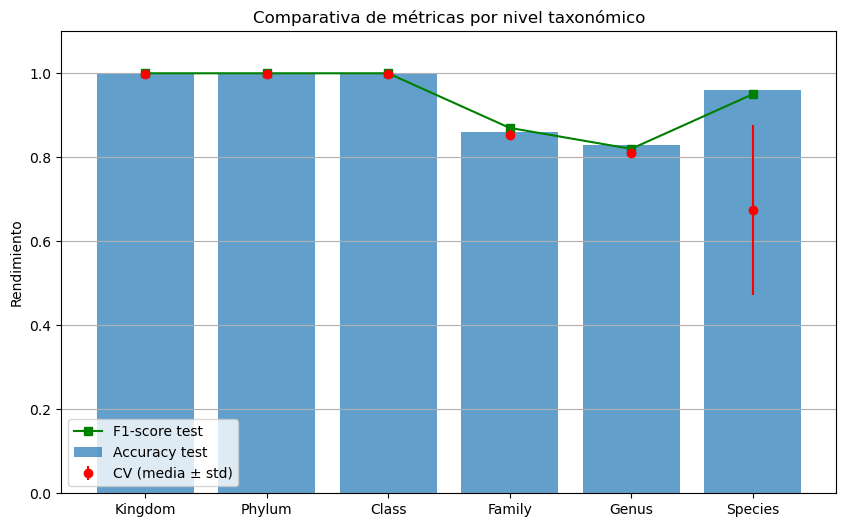

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Accuracy test
plt.bar(niveles, acc_test, alpha=0.7, label="Accuracy test")

# f1-score test
plt.plot(niveles, f1_test, marker="s", color="green", label="F1-score test")

# Validación cruzada con barras de error
plt.errorbar(niveles, cv_mean, yerr=cv_std, fmt="o", color="red", label="CV (media ± std)")

plt.ylim(0, 1.1)
plt.ylabel("Rendimiento")
plt.title("Comparativa de métricas por nivel taxonómico")
plt.grid(axis="y")
plt.legend()
plt.show()

In [9]:
import pandas as pd
import numpy as np

# --------------------------
# PARÁMETROS Y CARGAS NECESARIAS
# --------------------------

ruta_cluster_genus = "/home/alumno08/TFM/fase2/9_correciones_modelo/genus_clustering_con_rendimiento.tsv"
ruta_cluster_species = "/home/alumno08/TFM/fase2/9_correciones_modelo/species_clustering_con_rendimiento.tsv"
ruta_phrogs_species = "/home/alumno08/TFM/fase2/5_phrogs/phrogs_especificos_por_species.tsv"
ruta_phrogs_genus = "/home/alumno08/TFM/fase2/5_phrogs/phrogs_especificos_por_genus.tsv"

# Dataset original y predicciones
df = pd.read_csv("/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv", sep="\t", index_col=0)
predicciones = pd.read_csv("/home/alumno08/TFM/fase2/10_modelo_final_por_nivel/predicciones_completas_con_avisos.tsv", sep="\t", index_col=0)

# Carga de tablas auxiliares
tabla_clusters_genus = pd.read_csv(ruta_cluster_genus, sep="\t")
tabla_clusters_species = pd.read_csv(ruta_cluster_species, sep="\t")
phrogs_genus = pd.read_csv(ruta_phrogs_genus, sep="\t")
phrogs_species = pd.read_csv(ruta_phrogs_species, sep="\t")

phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]

# --------------------------
# GENERACIÓN DE AVISOS Y MÉTRICAS EXTRAS
# --------------------------

avisos = []
n_phrogs_esp_genus = []
n_phrogs_esp_species = []

for idx in predicciones.index:
    aviso = []
    genus_pred = predicciones.loc[idx, "Genus"]
    species_pred = predicciones.loc[idx, "Species"]
    conf_genus = predicciones.loc[idx, "Confianza_Genus"]
    conf_species = predicciones.loc[idx, "Confianza_Species"]

    # AVISO POR CLUSTER PROBLEMÁTICO
    info_genus = tabla_clusters_genus[tabla_clusters_genus["Genus"].str.lower() == genus_pred.lower()]
    if not info_genus.empty and info_genus.iloc[0]["cluster"] in [0, 1]:
        aviso.append("Genus en cluster problemático")
    
    info_species = tabla_clusters_species[tabla_clusters_species["Species"].str.lower() == species_pred.lower()]
    if not info_species.empty and info_species.iloc[0]["cluster"] != 3:
        aviso.append("Species en cluster problemático")
    
    # AVISO POR BAJA CONFIANZA
    if conf_genus < 0.7:
        aviso.append("Baja confianza Genus")
    if conf_species < 0.7:
        aviso.append("Baja confianza Species")

    # CÁLCULO DE PHROGs exclusivos presentes
    presentes = df.loc[idx, phrog_cols][df.loc[idx, phrog_cols] == 1].index.tolist()

    phrogs_esp_genus = phrogs_genus[genus_pred].dropna().tolist() if genus_pred in phrogs_genus.columns else []
    phrogs_esp_species = phrogs_species[species_pred].dropna().tolist() if species_pred in phrogs_species.columns else []

    n_genus = len(set(presentes) & set(phrogs_esp_genus))
    n_species = len(set(presentes) & set(phrogs_esp_species))

    n_phrogs_esp_genus.append(n_genus)
    n_phrogs_esp_species.append(n_species)

    # AVISO SI NO TIENE PHROGs exclusivos presentes
    if n_genus == 0:
        aviso.append("Ningún PHROG exclusivo de Genus presente")
    if n_species == 0:
        aviso.append("Ningún PHROG exclusivo de Species presente")

    avisos.append("; ".join(aviso) if aviso else "OK")

# --------------------------
# GUARDADO DEL RESULTADO
# --------------------------

predicciones["N_PHROGs_exclusivos_Genus"] = n_phrogs_esp_genus
predicciones["N_PHROGs_exclusivos_Species"] = n_phrogs_esp_species
predicciones["Aviso_detalado"] = avisos

predicciones.to_csv("/home/alumno08/TFM/fase2/10_modelo_final_por_nivel/predicciones_con_avisos_detallados.tsv", sep="\t")

print(" Avisos y métricas adicionales generados y guardados correctamente.")

/tmp/ipykernel_580320/2298157494.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv", sep="\t", index_col=0)


 Avisos y métricas adicionales generados y guardados correctamente.


In [9]:
import pandas as pd
import numpy as np

# --------------------------
# PARÁMETROS Y CARGAS NECESARIAS
# --------------------------

ruta_cluster_genus = "/home/alumno08/TFM/fase2/9_correciones_modelo/genus_clustering_con_rendimiento.tsv"
ruta_cluster_species = "/home/alumno08/TFM/fase2/9_correciones_modelo/species_clustering_con_rendimiento.tsv"
ruta_phrogs_species = "/home/alumno08/TFM/fase2/5_phrogs/phrogs_especificos_por_species.tsv"
ruta_phrogs_genus = "/home/alumno08/TFM/fase2/5_phrogs/phrogs_especificos_por_genus.tsv"

# Dataset original y predicciones
df = pd.read_csv("/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv", sep="\t", index_col=0)
predicciones = pd.read_csv("/home/alumno08/TFM/fase2/10_modelo_final_por_nivel/predicciones_completas_con_avisos.tsv", sep="\t", index_col=0)

# Carga de tablas auxiliares
tabla_clusters_genus = pd.read_csv(ruta_cluster_genus, sep="\t")
tabla_clusters_species = pd.read_csv(ruta_cluster_species, sep="\t")
phrogs_genus = pd.read_csv(ruta_phrogs_genus, sep="\t")
phrogs_species = pd.read_csv(ruta_phrogs_species, sep="\t")

phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]

# --------------------------
# GENERACIÓN DE AVISOS Y MÉTRICAS EXTRAS
# --------------------------

avisos = []
n_phrogs_esp_genus = []
n_phrogs_esp_species = []

for idx in predicciones.index:
    aviso = []
    genus_pred = predicciones.loc[idx, "Genus"]
    species_pred = predicciones.loc[idx, "Species"]
    conf_genus = predicciones.loc[idx, "Confianza_Genus"]
    conf_species = predicciones.loc[idx, "Confianza_Species"]

    # AVISO POR CLUSTER PROBLEMÁTICO
    info_genus = tabla_clusters_genus[tabla_clusters_genus["Genus"].str.lower() == genus_pred.lower()]
    if not info_genus.empty and info_genus.iloc[0]["cluster"] in [0, 1]:
        aviso.append("Genus en cluster problemático")
    
    info_species = tabla_clusters_species[tabla_clusters_species["Species"].str.lower() == species_pred.lower()]
    if not info_species.empty and info_species.iloc[0]["cluster"] != 3:
        aviso.append("Species en cluster problemático")
    
    # AVISO POR BAJA CONFIANZA
    if conf_genus < 0.7:
        aviso.append("Baja confianza Genus")
    if conf_species < 0.7:
        aviso.append("Baja confianza Species")

    # CÁLCULO DE PHROGs exclusivos presentes
    presentes = df.loc[idx, phrog_cols][df.loc[idx, phrog_cols] == 1].index.tolist()

    phrogs_esp_genus = phrogs_genus[genus_pred].dropna().tolist() if genus_pred in phrogs_genus.columns else []
    phrogs_esp_species = phrogs_species[species_pred].dropna().tolist() if species_pred in phrogs_species.columns else []

    n_genus = len(set(presentes) & set(phrogs_esp_genus))
    n_species = len(set(presentes) & set(phrogs_esp_species))

    n_phrogs_esp_genus.append(n_genus)
    n_phrogs_esp_species.append(n_species)

    # AVISO SI NO TIENE PHROGs exclusivos presentes
    if n_genus == 0:
        aviso.append("Ningún PHROG exclusivo de Genus presente")
    if n_species == 0:
        aviso.append("Ningún PHROG exclusivo de Species presente")

    avisos.append("; ".join(aviso) if aviso else "OK")

# --------------------------
# GUARDADO DEL RESULTADO
# --------------------------

predicciones["N_PHROGs_exclusivos_Genus"] = n_phrogs_esp_genus
predicciones["N_PHROGs_exclusivos_Species"] = n_phrogs_esp_species
predicciones["Aviso_detalado"] = avisos

predicciones.to_csv("/home/alumno08/TFM/fase2/10_modelo_final_por_nivel/predicciones_con_avisos_detallados.tsv", sep="\t")

print(" Avisos y métricas adicionales generados y guardados correctamente.")

/tmp/ipykernel_580320/2298157494.py:14: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv", sep="\t", index_col=0)


 Avisos y métricas adicionales generados y guardados correctamente.


In [1]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# --------------------------
# PARÁMETROS GENERALES
# --------------------------

ruta_matriz = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_guardado_base = "/home/alumno08/TFM/fase2/10_modelo_final_por_nivel"
os.makedirs(ruta_guardado_base, exist_ok=True)

random_state = 42

# --------------------------
# CARGA DE DATOS
# --------------------------

df = pd.read_csv(ruta_matriz, sep="\t", index_col=0, low_memory=False)
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]
df = df.dropna(subset=["Species"])

# --------------------------
# CARGA DE PHROGs ESPECÍFICOS Y CARACTERÍSTICOS PARA Species
# --------------------------

df_esp = pd.read_csv(f"{ruta_phrogs}/phrogs_especificos_por_species.tsv", sep="\t")
df_carac = pd.read_csv(f"{ruta_phrogs}/phrogs_caracteristicos_por_species.tsv", sep="\t")

# --------------------------
# GENERACIÓN DE NUEVOS PREDICTORES CON REFUERZO
# --------------------------

num_esp, num_carac = [], []
for idx, fila in df.iterrows():
    grupo = fila["Species"]
    phrogs_esp_grupo = df_esp[grupo].dropna().tolist() if grupo in df_esp.columns else []
    phrogs_carac_grupo = df_carac[grupo].dropna().tolist() if grupo in df_carac.columns else []
    presentes = fila[phrog_cols][fila[phrog_cols] == 1].index.tolist()
    num_esp.append(10 * len(set(presentes) & set(phrogs_esp_grupo)))
    num_carac.append(len(set(presentes) & set(phrogs_carac_grupo)))

df_extra = pd.DataFrame({
    "especificos_species": num_esp,
    "caracteristicos_species": num_carac
}, index=df.index)

X = pd.concat([df[phrog_cols], df_extra], axis=1)
y = df["Species"]

# --------------------------
# FILTRADO Y DIVISIÓN CON TEST MÁS GRANDE PARA EVITAR ERRORES
# --------------------------

clases_validas = y.value_counts()[y.value_counts() >= 2].index
mask = y.isin(clases_validas)
X_filtrado = X[mask]
y_filtrado = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y_filtrado, test_size=0.4, stratify=y_filtrado, random_state=random_state
)

# --------------------------
# CÁLCULO DE PESOS Y ENTRENAMIENTO FINAL
# --------------------------

class_counts = y_train.value_counts()
total = len(y_train)
pesos = {clase: total / (len(class_counts) * count) for clase, count in class_counts.items()}

rf = RandomForestClassifier(random_state=random_state, class_weight=pesos)
param_grid = {"n_estimators": [100], "max_depth": [None, 10]}
grid = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
mejor_modelo = grid.best_estimator_

# --------------------------
# VALIDACIÓN CRUZADA Y EVALUACIÓN FINAL
# --------------------------

scores = cross_val_score(mejor_modelo, X_train, y_train, cv=5)
print(f"Validación cruzada (media ± std): {scores.mean():.3f} ± {scores.std():.3f}")

y_pred = mejor_modelo.predict(X_test)
print("\nEvaluación en conjunto de test:")
print(classification_report(y_test, y_pred))

# --------------------------
# GUARDADO DEL MODELO
# --------------------------

with open(f"{ruta_guardado_base}/modelo_species_10.pkl", "wb") as f:
    pickle.dump(mejor_modelo, f)

print("✅ Modelo final para Species entrenado y guardado correctamente.")

/tmp/ipykernel_745179/2626271275.py:33: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.675 ± 0.203

Evaluación en conjunto de test:
                      precision    recall  f1-score   support

    Agatevirus Bp8pC       1.00      1.00      1.00         1
    Bequatrovirus B4       1.00      1.00      1.00         1
     Coriovirus Cf1c       1.00      1.00      1.00         1
      Fibrovirus fs1       1.00      1.00      1.00         2
   Habenivirus RS551       1.00      1.00      1.00         1
    Habenivirus RSM3       1.00      1.00      1.00         1
        Inovirus M13       1.00      1.00      1.00         5
         Kayvirus G1       1.00      1.00      1.00         6
Pecentumvirus LMSP25       1.00      1.00      1.00         1
 Pecentumvirus LP064       0.50      1.00      0.67         1
Pecentumvirus LP0832       0.00      0.00      0.00         1
     Restivirus RSS1       1.00      1.00      1.00         1
   Silviavirus remus       1.00      1.00      1.00         1
  Tertilicivirus Pf3       1.00      1.00      1.0

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [2]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# --------------------------
# PARÁMETROS GENERALES
# --------------------------

ruta_matriz = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_guardado_base = "/home/alumno08/TFM/fase2/10_modelo_final_por_nivel"
os.makedirs(ruta_guardado_base, exist_ok=True)

random_state = 42

# --------------------------
# CARGA DE DATOS
# --------------------------

df = pd.read_csv(ruta_matriz, sep="\t", index_col=0, low_memory=False)
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]
df = df.dropna(subset=["Species"])

# --------------------------
# CARGA DE PHROGs ESPECÍFICOS Y CARACTERÍSTICOS PARA Species
# --------------------------

df_esp = pd.read_csv(f"{ruta_phrogs}/phrogs_especificos_por_species.tsv", sep="\t")
df_carac = pd.read_csv(f"{ruta_phrogs}/phrogs_caracteristicos_por_species.tsv", sep="\t")

# --------------------------
# GENERACIÓN DE NUEVOS PREDICTORES CON REFUERZO
# --------------------------

num_esp, num_carac = [], []
for idx, fila in df.iterrows():
    grupo = fila["Species"]
    phrogs_esp_grupo = df_esp[grupo].dropna().tolist() if grupo in df_esp.columns else []
    phrogs_carac_grupo = df_carac[grupo].dropna().tolist() if grupo in df_carac.columns else []
    presentes = fila[phrog_cols][fila[phrog_cols] == 1].index.tolist()
    num_esp.append(50 * len(set(presentes) & set(phrogs_esp_grupo)))
    num_carac.append(len(set(presentes) & set(phrogs_carac_grupo)))

df_extra = pd.DataFrame({
    "especificos_species": num_esp,
    "caracteristicos_species": num_carac
}, index=df.index)

X = pd.concat([df[phrog_cols], df_extra], axis=1)
y = df["Species"]

# --------------------------
# FILTRADO Y DIVISIÓN CON TEST MÁS GRANDE PARA EVITAR ERRORES
# --------------------------

clases_validas = y.value_counts()[y.value_counts() >= 2].index
mask = y.isin(clases_validas)
X_filtrado = X[mask]
y_filtrado = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y_filtrado, test_size=0.4, stratify=y_filtrado, random_state=random_state
)

# --------------------------
# CÁLCULO DE PESOS Y ENTRENAMIENTO FINAL
# --------------------------

class_counts = y_train.value_counts()
total = len(y_train)
pesos = {clase: total / (len(class_counts) * count) for clase, count in class_counts.items()}

rf = RandomForestClassifier(random_state=random_state, class_weight=pesos)
param_grid = {"n_estimators": [100], "max_depth": [None, 10]}
grid = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
mejor_modelo = grid.best_estimator_

# --------------------------
# VALIDACIÓN CRUZADA Y EVALUACIÓN FINAL
# --------------------------

scores = cross_val_score(mejor_modelo, X_train, y_train, cv=5)
print(f"Validación cruzada (media ± std): {scores.mean():.3f} ± {scores.std():.3f}")

y_pred = mejor_modelo.predict(X_test)
print("\nEvaluación en conjunto de test:")
print(classification_report(y_test, y_pred))

# --------------------------
# GUARDADO DEL MODELO
# --------------------------

with open(f"{ruta_guardado_base}/modelo_species_50.pkl", "wb") as f:
    pickle.dump(mejor_modelo, f)

print("✅ Modelo final para Species entrenado y guardado correctamente.")

/tmp/ipykernel_745179/371891811.py:33: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.675 ± 0.203

Evaluación en conjunto de test:
                      precision    recall  f1-score   support

    Agatevirus Bp8pC       1.00      1.00      1.00         1
    Bequatrovirus B4       1.00      1.00      1.00         1
     Coriovirus Cf1c       1.00      1.00      1.00         1
      Fibrovirus fs1       1.00      1.00      1.00         2
   Habenivirus RS551       1.00      1.00      1.00         1
    Habenivirus RSM3       1.00      1.00      1.00         1
        Inovirus M13       1.00      1.00      1.00         5
         Kayvirus G1       1.00      1.00      1.00         6
Pecentumvirus LMSP25       1.00      1.00      1.00         1
 Pecentumvirus LP064       0.50      1.00      0.67         1
Pecentumvirus LP0832       0.00      0.00      0.00         1
     Restivirus RSS1       1.00      1.00      1.00         1
   Silviavirus remus       1.00      1.00      1.00         1
  Tertilicivirus Pf3       1.00      1.00      1.0

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [4]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# --------------------------
# PARÁMETROS GENERALES
# --------------------------

ruta_matriz = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_guardado_base = "/home/alumno08/TFM/fase2/10_modelo_final_por_nivel"
os.makedirs(ruta_guardado_base, exist_ok=True)

random_state = 42

# --------------------------
# CARGA DE DATOS
# --------------------------

df = pd.read_csv(ruta_matriz, sep="\t", index_col=0, low_memory=False)
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]
df = df.dropna(subset=["Species"])

# --------------------------
# CARGA DE PHROGs ESPECÍFICOS Y CARACTERÍSTICOS PARA Species
# --------------------------

df_esp = pd.read_csv(f"{ruta_phrogs}/phrogs_especificos_por_species.tsv", sep="\t")
df_carac = pd.read_csv(f"{ruta_phrogs}/phrogs_caracteristicos_por_species.tsv", sep="\t")

# --------------------------
# GENERACIÓN DE NUEVOS PREDICTORES CON REFUERZO
# --------------------------

num_esp, num_carac = [], []
for idx, fila in df.iterrows():
    grupo = fila["Species"]
    phrogs_esp_grupo = df_esp[grupo].dropna().tolist() if grupo in df_esp.columns else []
    phrogs_carac_grupo = df_carac[grupo].dropna().tolist() if grupo in df_carac.columns else []
    presentes = fila[phrog_cols][fila[phrog_cols] == 1].index.tolist()
    num_esp.append(50 * len(set(presentes) & set(phrogs_esp_grupo)))
    num_carac.append(0.5 * len(set(presentes) & set(phrogs_carac_grupo)))

df_extra = pd.DataFrame({
    "especificos_species": num_esp,
    "caracteristicos_species": num_carac
}, index=df.index)

X = pd.concat([df[phrog_cols], df_extra], axis=1)
y = df["Species"]

# --------------------------
# FILTRADO Y DIVISIÓN CON TEST MÁS GRANDE PARA EVITAR ERRORES
# --------------------------

clases_validas = y.value_counts()[y.value_counts() >= 2].index
mask = y.isin(clases_validas)
X_filtrado = X[mask]
y_filtrado = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y_filtrado, test_size=0.4, stratify=y_filtrado, random_state=random_state
)

# --------------------------
# CÁLCULO DE PESOS Y ENTRENAMIENTO FINAL
# --------------------------

class_counts = y_train.value_counts()
total = len(y_train)
pesos = {clase: total / (len(class_counts) * count) for clase, count in class_counts.items()}

rf = RandomForestClassifier(random_state=random_state, class_weight=pesos)
param_grid = {"n_estimators": [100], "max_depth": [None, 10]}
grid = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
mejor_modelo = grid.best_estimator_

# --------------------------
# VALIDACIÓN CRUZADA Y EVALUACIÓN FINAL
# --------------------------

scores = cross_val_score(mejor_modelo, X_train, y_train, cv=5)
print(f"Validación cruzada (media ± std): {scores.mean():.3f} ± {scores.std():.3f}")

y_pred = mejor_modelo.predict(X_test)
print("\nEvaluación en conjunto de test:")
print(classification_report(y_test, y_pred))

# --------------------------
# GUARDADO DEL MODELO
# --------------------------

with open(f"{ruta_guardado_base}/modelo_species_50.pkl", "wb") as f:
    pickle.dump(mejor_modelo, f)

print("✅ Modelo final para Species entrenado y guardado correctamente.")

/tmp/ipykernel_745179/1124983201.py:33: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.675 ± 0.203

Evaluación en conjunto de test:
                      precision    recall  f1-score   support

    Agatevirus Bp8pC       1.00      1.00      1.00         1
    Bequatrovirus B4       1.00      1.00      1.00         1
     Coriovirus Cf1c       1.00      1.00      1.00         1
      Fibrovirus fs1       1.00      1.00      1.00         2
   Habenivirus RS551       1.00      1.00      1.00         1
    Habenivirus RSM3       1.00      1.00      1.00         1
        Inovirus M13       1.00      1.00      1.00         5
         Kayvirus G1       1.00      1.00      1.00         6
Pecentumvirus LMSP25       1.00      1.00      1.00         1
 Pecentumvirus LP064       0.50      1.00      0.67         1
Pecentumvirus LP0832       0.00      0.00      0.00         1
     Restivirus RSS1       1.00      1.00      1.00         1
   Silviavirus remus       1.00      1.00      1.00         1
  Tertilicivirus Pf3       1.00      1.00      1.0

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

In [1]:
import pandas as pd
import pickle
import os

# Rutas
ruta_dataset_entrenamiento = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
ruta_guardado_columnas = "/home/alumno08/TFM/fase2/10_modelo_final_por_nivel"

# Carga del dataset de entrenamiento
df = pd.read_csv(ruta_dataset_entrenamiento, sep="\t", index_col=0)

# Identificación de las columnas relevantes
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]
caracteristicos_cols = [col for col in df.columns if col.startswith("caracteristicos_")]
otras_cols = ["genome_length", "gc_percent", "num_genes"]  # Ajusta si añadiste más

# Lista de columnas final en el orden correcto
columnas_usadas = phrog_cols + caracteristicos_cols + otras_cols

# Guardado de la lista para cada nivel (por comodidad, aunque es la misma)
niveles = ["kingdom", "phylum", "class", "family", "genus", "species"]

for nivel in niveles:
    ruta = os.path.join(ruta_guardado_columnas, f"columnas_{nivel}.pkl")
    with open(ruta, "wb") as f:
        pickle.dump(columnas_usadas, f)
    print(f"Lista de columnas guardada en {ruta}")

/tmp/ipykernel_772380/2048486962.py:10: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(ruta_dataset_entrenamiento, sep="\t", index_col=0)


Lista de columnas guardada en /home/alumno08/TFM/fase2/10_modelo_final_por_nivel/columnas_kingdom.pkl
Lista de columnas guardada en /home/alumno08/TFM/fase2/10_modelo_final_por_nivel/columnas_phylum.pkl
Lista de columnas guardada en /home/alumno08/TFM/fase2/10_modelo_final_por_nivel/columnas_class.pkl
Lista de columnas guardada en /home/alumno08/TFM/fase2/10_modelo_final_por_nivel/columnas_family.pkl
Lista de columnas guardada en /home/alumno08/TFM/fase2/10_modelo_final_por_nivel/columnas_genus.pkl
Lista de columnas guardada en /home/alumno08/TFM/fase2/10_modelo_final_por_nivel/columnas_species.pkl


In [2]:
import pandas as pd
import numpy as np
import pickle
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# --------------------------
# PARÁMETROS GENERALES
# --------------------------

ruta_matriz = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
ruta_phrogs = "/home/alumno08/TFM/fase2/5_phrogs"
ruta_guardado_base = "/home/alumno08/TFM/fase2/10_modelo_final_por_nivel"
os.makedirs(ruta_guardado_base, exist_ok=True)

random_state = 42

# --------------------------
# CARGA DE DATOS
# --------------------------

df = pd.read_csv(ruta_matriz, sep="\t", index_col=0, low_memory=False)
phrog_cols = [col for col in df.columns if col.startswith("PHROG_")]
df = df.dropna(subset=["Species"])

# --------------------------
# CARGA DE PHROGs ESPECÍFICOS Y CARACTERÍSTICOS PARA Species
# --------------------------

df_esp = pd.read_csv(f"{ruta_phrogs}/phrogs_especificos_por_species.tsv", sep="\t")
df_carac = pd.read_csv(f"{ruta_phrogs}/phrogs_caracteristicos_por_species.tsv", sep="\t")

# --------------------------
# GENERACIÓN DE NUEVOS PREDICTORES CON REFUERZO
# --------------------------

num_esp, num_carac = [], []
for idx, fila in df.iterrows():
    grupo = fila["Species"]
    phrogs_esp_grupo = df_esp[grupo].dropna().tolist() if grupo in df_esp.columns else []
    phrogs_carac_grupo = df_carac[grupo].dropna().tolist() if grupo in df_carac.columns else []
    presentes = fila[phrog_cols][fila[phrog_cols] == 1].index.tolist()
    num_esp.append(3 * len(set(presentes) & set(phrogs_esp_grupo)))
    num_carac.append(len(set(presentes) & set(phrogs_carac_grupo)))

df_extra = pd.DataFrame({
    "especificos_species": num_esp,
    "caracteristicos_species": num_carac
}, index=df.index)

X = pd.concat([df[phrog_cols], df_extra], axis=1)
y = df["Species"]

# --------------------------
# FILTRADO Y DIVISIÓN
# --------------------------

clases_validas = y.value_counts()[y.value_counts() >= 2].index
mask = y.isin(clases_validas)
X_filtrado = X[mask]
y_filtrado = y[mask]

X_train, X_test, y_train, y_test = train_test_split(
    X_filtrado, y_filtrado, test_size=0.4, stratify=y_filtrado, random_state=random_state
)

# --------------------------
# CÁLCULO DE PESOS Y ENTRENAMIENTO FINAL
# --------------------------

class_counts = y_train.value_counts()
total = len(y_train)
pesos = {clase: total / (len(class_counts) * count) for clase, count in class_counts.items()}

rf = RandomForestClassifier(random_state=random_state, class_weight=pesos)
param_grid = {"n_estimators": [100], "max_depth": [None, 10]}
grid = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
mejor_modelo = grid.best_estimator_

# --------------------------
# VALIDACIÓN CRUZADA Y EVALUACIÓN FINAL
# --------------------------

scores = cross_val_score(mejor_modelo, X_train, y_train, cv=5)
print(f"Validación cruzada (media ± std): {scores.mean():.3f} ± {scores.std():.3f}")

y_pred = mejor_modelo.predict(X_test)
print("\nEvaluación en conjunto de test:")
print(classification_report(y_test, y_pred))

# --------------------------
# GUARDADO DEL MODELO Y METADATOS
# --------------------------

with open(f"{ruta_guardado_base}/modelo_species2.pkl", "wb") as f:
    pickle.dump(mejor_modelo, f)

# Guardado de columnas usadas
columnas_usadas = X.columns.tolist()
with open(f"{ruta_guardado_base}/columnas_species.pkl", "wb") as f:
    pickle.dump(columnas_usadas, f)

# Guardado de especies usadas en el entrenamiento
especies_entrenadas = y_filtrado.unique()
with open(f"{ruta_guardado_base}/especies_entrenadas.pkl", "wb") as f:
    pickle.dump(especies_entrenadas, f)

print("✅ Modelo final, columnas y listado de especies entrenadas guardados correctamente.")

/tmp/ipykernel_772380/4227257223.py:33: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261

Fitting 3 folds for each of 2 candidates, totalling 6 fits


/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Validación cruzada (media ± std): 0.675 ± 0.203

Evaluación en conjunto de test:
                      precision    recall  f1-score   support

    Agatevirus Bp8pC       1.00      1.00      1.00         1
    Bequatrovirus B4       1.00      1.00      1.00         1
     Coriovirus Cf1c       1.00      1.00      1.00         1
      Fibrovirus fs1       1.00      1.00      1.00         2
   Habenivirus RS551       1.00      1.00      1.00         1
    Habenivirus RSM3       1.00      1.00      1.00         1
        Inovirus M13       1.00      1.00      1.00         5
         Kayvirus G1       1.00      1.00      1.00         6
Pecentumvirus LMSP25       1.00      1.00      1.00         1
 Pecentumvirus LP064       0.50      1.00      0.67         1
Pecentumvirus LP0832       0.00      0.00      0.00         1
     Restivirus RSS1       1.00      1.00      1.00         1
   Silviavirus remus       1.00      1.00      1.00         1
  Tertilicivirus Pf3       1.00      1.00      1.0

/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/modules/anaconda_new/python39/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitaliz

Total de genomas antes del filtrado: 6692
Total de especies antes del filtrado: 6643

Tras el filtrado:
Genomas restantes: 68
Especies restantes: 19


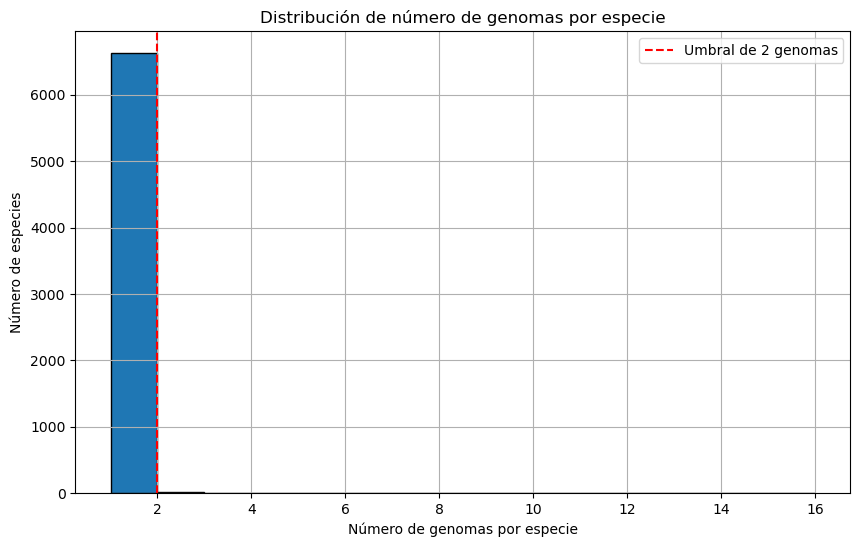

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Carga de datos
ruta_matriz = "/home/alumno08/TFM/fase2/matriz_phrogs_tax_gc_final.tsv"
df = pd.read_csv(ruta_matriz, sep="\t", index_col=0, low_memory=False)

# Filtrado de filas sin especie
df = df.dropna(subset=["Species"])

# Estadísticas antes del filtrado
total_genomas = df.shape[0]
total_species = df["Species"].nunique()

print(f"Total de genomas antes del filtrado: {total_genomas}")
print(f"Total de especies antes del filtrado: {total_species}")

# Conteo de genomas por especie
conteo_species = df["Species"].value_counts()

# Especies que se quedan tras el filtrado
especies_filtradas = conteo_species[conteo_species >= 2].index.tolist()
df_filtrado = df[df["Species"].isin(especies_filtradas)]

total_genomas_filtrado = df_filtrado.shape[0]
total_species_filtrado = df_filtrado["Species"].nunique()

print(f"\nTras el filtrado:")
print(f"Genomas restantes: {total_genomas_filtrado}")
print(f"Especies restantes: {total_species_filtrado}")

# Visualización
plt.figure(figsize=(10,6))
conteo_species.hist(bins=range(1, conteo_species.max()+2), edgecolor="black")
plt.axvline(2, color="red", linestyle="--", label="Umbral de 2 genomas")
plt.title("Distribución de número de genomas por especie")
plt.xlabel("Número de genomas por especie")
plt.ylabel("Número de especies")
plt.legend()
plt.show()